# DDR Demonstration: 3D Gaussian Dataset

This demo showcases the application of Discriminative Dimensionality Reduction (DDR) on a simulated 3D Gaussian dataset.

## Dataset
- **3D Gaussian**: Six classes of data points sampled from 3D Gaussian distributions
- 5,000 data points per class

## Method
1. Generate 3D Gaussian data
2. Map data to 100 dimensions using random matrices
3. Apply DDR to learn 2D features

## Visualization
- 2D features learned by DDR are displayed
- Distributions projected onto unit circle for clarity

This demonstration shows DDR's ability to disentangle high-dimensional data into interpretable low-dimensional representations while maintaining class separability.



## Imports and Setup

In [1]:
# basic functions
import os
import sys
import math
import numpy as np
import shutil
import setproctitle
import argparse
import matplotlib.pyplot as plt

# torch functions
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# local functions
from model import *
from toys import toy_2d, toy_3d
from densenet_sim import DenseNet

parser = argparse.ArgumentParser()
parser.add_argument('--batchSz', type=int, default=128, help='mini batch size')
parser.add_argument('--nEpochs', type=int, default=30, help='the number of outter loop')
parser.add_argument('--latent_dim', type=int, default=2, help='the dimension of latent space')
parser.add_argument('--no-cuda', action='store_true', help='if TRUE, cuda will not be used')
parser.add_argument('--cuda_device', type=int, default=0, help='choose cuda device')
parser.add_argument('--save', help='path to save results')
parser.add_argument('--seed', type=int, default=1, help='random seed')
parser.add_argument('--dataset', type=int, default=3, help='1: circles data; 2: moons data; 3: 3d guassian data')
parser.add_argument(
        '-f',
        '--file',
        help='Path for input file. First line should contain number of lines to search in'
    )
args = parser.parse_args()

args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")
args.save = args.save or 'Results/toys'
setproctitle.setproctitle(args.save)

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    torch.cuda.set_device(args.cuda_device)

if os.path.exists(args.save):
    shutil.rmtree(args.save)
os.makedirs(args.save, exist_ok=True)

## Simulated data loading

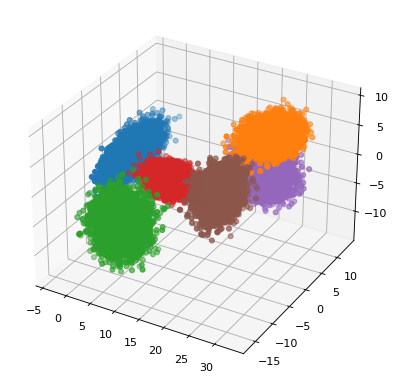

In [2]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

# get dataloaders
if (args.dataset == 1) or (args.dataset == 2):
    X_train, X_test, y_train, y_test = toy_2d(args, sample_size = 10000)
elif args.dataset == 3:
    X_train, X_test, y_train, y_test = toy_3d(args, single_size=5000)

train_dat = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
trainLoader = DataLoader(train_dat, batch_size=args.batchSz, shuffle=True)
test_dat = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
testLoader = DataLoader(test_dat, batch_size=args.batchSz, shuffle=False)

## Training process

In [3]:
# nets and optimizers setting
R_net = DenseNet(growthRate=12, depth=10, reduction=0.5,
                 bottleneck=True, ndim = args.latent_dim, nClasses=10)
D_net = Discriminator(ndim = args.latent_dim)

print('  + Number of params (R net) : {}'.format(
    sum([p.data.nelement() for p in R_net.parameters()])))
print('  + Number of params (D net) : {}'.format(
    sum([p.data.nelement() for p in D_net.parameters()])))

if args.cuda:
    R_net = R_net.cuda()
    D_net = D_net.cuda()

optimizer_R = optim.Adam(R_net.parameters(), weight_decay=1e-4)
optimizer_D = optim.Adam(D_net.parameters(), weight_decay=1e-4)

trainF = open(os.path.join(args.save, 'train.csv'), 'w')
testF = open(os.path.join(args.save, 'test.csv'), 'w')

  + Number of params (R net) : 20276
  + Number of params (D net) : 16833


Train Epoch: 1, Loss: 5.1337, Error: 100.0000, dCor_loss: 0.6496, VG: 0.0609, D: 0.69, OG: 0.68
Train Epoch: 2, Loss: 5.0541, Error: 100.0000, dCor_loss: 0.6016, VG: 0.8047, D: 0.71, OG: 0.72
Train Epoch: 3, Loss: 4.7975, Error: 99.1667, dCor_loss: 0.5783, VG: 0.0671, D: 0.71, OG: 0.70
Train Epoch: 4, Loss: 4.7546, Error: 94.1667, dCor_loss: 0.6007, VG: 0.0883, D: 0.71, OG: 0.66
Train Epoch: 5, Loss: 4.7377, Error: 77.5000, dCor_loss: 0.5922, VG: 0.0442, D: 0.68, OG: 0.65
Train Epoch: 6, Loss: 4.7114, Error: 80.8333, dCor_loss: 0.6387, VG: 0.0507, D: 0.69, OG: 0.67
Train Epoch: 7, Loss: 4.7707, Error: 87.5000, dCor_loss: 0.6083, VG: 0.0678, D: 0.70, OG: 0.72
Train Epoch: 8, Loss: 4.7737, Error: 98.3333, dCor_loss: 0.6678, VG: 0.0416, D: 0.70, OG: 0.71
Train Epoch: 9, Loss: 4.7226, Error: 84.1667, dCor_loss: 0.5547, VG: 0.3677, D: 0.67, OG: 0.78
Train Epoch: 10, Loss: 4.7163, Error: 76.6667, dCor_loss: 0.6282, VG: 0.0448, D: 0.69, OG: 0.66


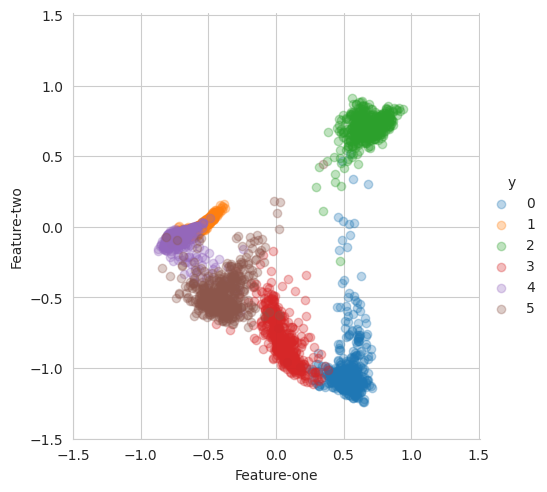

Train Epoch: 11, Loss: 4.8271, Error: 100.0000, dCor_loss: 0.5880, VG: 0.1435, D: 0.68, OG: 0.77
Train Epoch: 12, Loss: 4.8515, Error: 98.3333, dCor_loss: 0.6039, VG: 0.6926, D: 0.68, OG: 0.73
Train Epoch: 13, Loss: 4.8757, Error: 100.0000, dCor_loss: 0.6449, VG: 0.0342, D: 0.68, OG: 0.71
Train Epoch: 14, Loss: 4.7594, Error: 95.0000, dCor_loss: 0.6188, VG: 0.0519, D: 0.69, OG: 0.67
Train Epoch: 15, Loss: 4.8208, Error: 97.5000, dCor_loss: 0.5921, VG: 0.0295, D: 0.69, OG: 0.68
Train Epoch: 16, Loss: 5.0234, Error: 100.0000, dCor_loss: 0.6548, VG: 0.0195, D: 0.69, OG: 0.71
Train Epoch: 17, Loss: 4.9168, Error: 100.0000, dCor_loss: 0.5963, VG: 0.0322, D: 0.69, OG: 0.69
Train Epoch: 18, Loss: 5.0287, Error: 100.0000, dCor_loss: 0.5803, VG: 0.0468, D: 0.69, OG: 0.69
Train Epoch: 19, Loss: 4.9078, Error: 100.0000, dCor_loss: 0.6310, VG: 0.0344, D: 0.69, OG: 0.68
Train Epoch: 20, Loss: 4.8624, Error: 99.1667, dCor_loss: 0.6452, VG: 0.4576, D: 0.66, OG: 0.71


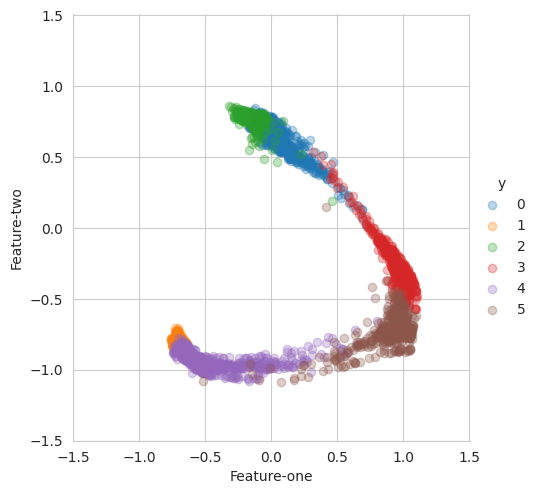

Train Epoch: 21, Loss: 4.9008, Error: 98.3333, dCor_loss: 0.6293, VG: 0.3432, D: 0.68, OG: 0.68
Train Epoch: 22, Loss: 4.7611, Error: 95.0000, dCor_loss: 0.6207, VG: 0.1039, D: 0.69, OG: 0.66
Train Epoch: 23, Loss: 4.8182, Error: 100.0000, dCor_loss: 0.6211, VG: 0.0338, D: 0.69, OG: 0.68
Train Epoch: 24, Loss: 4.7539, Error: 81.6667, dCor_loss: 0.6134, VG: 0.0255, D: 0.69, OG: 0.69
Train Epoch: 25, Loss: 4.7712, Error: 87.5000, dCor_loss: 0.6116, VG: 0.0199, D: 0.69, OG: 0.71
Train Epoch: 26, Loss: 4.8258, Error: 95.8333, dCor_loss: 0.6232, VG: 0.0449, D: 0.70, OG: 0.67
Train Epoch: 27, Loss: 4.8684, Error: 100.0000, dCor_loss: 0.6106, VG: 0.0389, D: 0.69, OG: 0.68
Train Epoch: 28, Loss: 4.7622, Error: 82.5000, dCor_loss: 0.6299, VG: 0.0201, D: 0.69, OG: 0.72
Train Epoch: 29, Loss: 4.8578, Error: 100.0000, dCor_loss: 0.6380, VG: 0.0053, D: 0.69, OG: 0.69
Train Epoch: 30, Loss: 5.0126, Error: 100.0000, dCor_loss: 0.6087, VG: 0.0179, D: 0.69, OG: 0.69


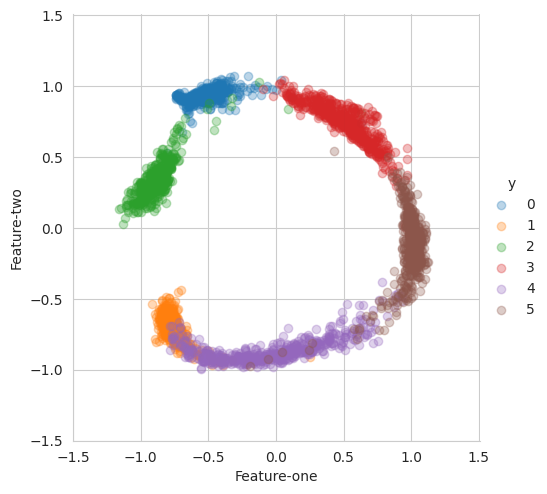

Done!


In [4]:
for epoch in range(1, args.nEpochs + 1):
    if epoch < 50: zlr = 2.0
    elif epoch == 50: zlr = 1.5
    elif epoch == 150: zlr = 1.0
    
    train(args, epoch, R_net, D_net, trainLoader, optimizer_R, optimizer_D, trainF, zlr, device)
    # test(args, epoch, R_net, testLoader, optimizer_R, testF, device)
        
    if epoch % 10 == 0:
        X_train, y_train = npLoader(trainLoader, R_net, device)
        X_test, y_test = npLoader(testLoader, R_net, device)
        scatter_plots(X_test, y_test)
        plt.show()

trainF.close()
testF.close()
print("Done!")